# Which phone features most significantly influence its price?

## Introduction (250)

People use phones daily, and scholars argue that these devices evolved from luxurious items into necessities over the past years (Tanveer et al.). We use them for "calling and sending messages, capturing pictures, accessing the internet, playing games, socializing, and downloading applications." They turned from mere communication tools into daily "multimedia machines" (Tanveer et al.).

Nevertheless, buying new phones can be challenging and frustrating due to the flood of features they offer (Kobie). To escape this tough choice, consumers usually consider only the advertised characteristics of the device without inquiring whether the phone price corresponds to them (K. Srujan Raju et al. 773). Hence, they are likely to make an uninformed decision and overpay.

Therefore, it is essential to create a **linear regression model that would predict a phone's market price given the device's set of characteristics**. It would help people evaluate whether the phone's proposed price aligns with the competition and is worth paying. 

However, our analysis assumes that the consumer does not have brand loyalty. If they do, our model becomes irrelevant to them because they are willing to pay a higher price without considering a cheaper substitution.

Thus, we want our model to help open-minded consumers quickly yet critically evaluate a phone's price tag and make a rational purchasing decision without being misled by advertising.

## Data set and Methods (300)

We use a data set containing specifications and prices for **1321** unique phone models. The researchers collected the observations via scraping [gadgets360.com](https://www.gadgets360.com/mobiles/best-phones) - an Indian tech news website - and published the [data set](https://www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices) in **2022** (Garai). 

Therefore, the data for our study is reliable and reasonably recent. Nevertheless, our analysis assumes that phone prices in the Indian market correspond to those in other countries, but it's not always the case. For example, iPhone prices in the US are significantly lower (Hilsenteger), so our data may only partially reflect the global market prices.

Here's the list of variables we will consider in our analysis. We rename them from the original data set, derive `resolution` from another two variables, and convert `price` from Indian Rupee to US Dollar to ease the investigation.

| Variable Name  | Description                                                 |
| -------------- | ----------------------------------------------------------- |
| `price`        | Phone price in USD                                          |
| `battery`      | Battery capacity in mAh                                     |
| `screen_size`  | Screen Size in Inches across opposite corners               |
| `touchscreen`  | Whether the phone is touchscreen supported or not           |
| `resolution`   | The resolution of the phone: (width $\times$ height) / 1000 |
| `processor`    | Number of processor cores                                   |
| `ram`          | RAM available in phone in GB                                |
| `storage`      | Internal Storage of phone in GB                             |
| `rear_camera`  | Resolution of rear camera in MP (0 if unavailable)          |
| `front_camera` | Resolution of front camera in MP (0 if unavailable)         |
| `os`           | Operating system used in phone                              |
| `gps`          | Whether phone has GPS functionality                         |
| `num_of_sims`  | Number of SIM card slots in phone                           |
| `x3g`          | Whether phone has 3G network functionality                  |
| `x4g_lte`      | Whether phone has 4G/LTE network functionality              |

We plan to create multiple linear regression models and assess their performance to choose the best one for this data. Specifically, we'll perform these steps:

#### 1. Preliminary Analysis:
- Read and wrangle the data
- Calculate summary statistics and visualize the association between `price` and other variables

#### 2. Models' Creation:
- Split the data into testing and training sets, **70% being the training set**
- Deal with possible **multicollinearity** between the input variables by:
    - Using **Variance Inflation Factor (VIF)** to detect it
    - Dropping highly correlated variables if multicollinearity is present
- Build these **Ordinary Least Squares (OLS)** models:
    - **Multiple Linear Regression (MLR) full model** using all input variables
    - **MLR model** using the variables chosen by a **stepwise forward variable selection** algorithm
    - **Simple Linear Regression (SLR) model** using the most significant variable from the stepwise variable selection
- Build a **Least Absolute Shrinkage and Selection Operator (LASSO)** regression model
    
    
#### 3. Models' Evaluation:
- Assess the performance of the models using **Mean Squared Error (MSE)**

## Preliminary Analysis (150)

Here's the code for performing the first point from the list above.

In [1]:
# Installing missing packages
# https://stackoverflow.com/a/4090208/18184038
package_list <- "psych"
to_install <- package_list[!(package_list %in% installed.packages()[, "Package"])]
if (length(to_install)) install.packages(to_install)

**(!!! change URL to the data set on the main branch)**

In [2]:
library(tidyverse)
library(psych)
library(GGally)
library(broom)
library(car)
library(leaps)
library(mltools)
library(glmnet)

set.seed(7)

# Reading the data set from the web
url <- "https://raw.githubusercontent.com/Ihor16/stat-301-project/ih/rewrite_for_new_dataset/data/specs.csv"
data_raw <- read.csv(url) %>%
  as_tibble()

# Previewing the raw data set
data_raw %>%
  head(3)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘psych’


The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:psych’:

    logit


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘mltools’


The following object is masked from ‘package:tidyr’:

    replace_na


Loading required package: Matrix


Attaching package: ‘Matr

X,Name,Brand,Model,Battery.capacity..mAh.,Screen.size..inches.,Touchscreen,Resolution.x,Resolution.y,Processor,⋯,Rear.camera,Front.camera,Operating.system,Wi.Fi,Bluetooth,GPS,Number.of.SIMs,X3G,X4G..LTE,Price
<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
0,OnePlus 7T Pro McLaren Edition,OnePlus,7T Pro McLaren Edition,4085,6.67,Yes,1440,3120,8,⋯,48,16,Android,Yes,Yes,Yes,2,Yes,Yes,58998
1,Realme X2 Pro,Realme,X2 Pro,4000,6.50,Yes,1080,2400,8,⋯,64,16,Android,Yes,Yes,Yes,2,Yes,Yes,27999
2,iPhone 11 Pro Max,Apple,iPhone 11 Pro Max,3969,6.50,Yes,1242,2688,6,⋯,12,12,iOS,Yes,Yes,Yes,2,Yes,Yes,106900


In [3]:
# Conversion rate from INR to USD
# https://www.forbes.com/advisor/money-transfer/currency-converter/inr-usd/
rate <- 0.012282

# Renaming the variables and creating a derived variable for `resolution`
phone_data <- data_raw %>%
  select(-c(X, Name, Brand, Model, "Wi.Fi", Bluetooth)) %>%
  rename(
    battery = "Battery.capacity..mAh.",
    screen_size = "Screen.size..inches.",
    touchscreen = "Touchscreen",
    resolution_x = "Resolution.x",
    resolution_y = "Resolution.y",
    processor = "Processor",
    ram = "RAM..MB.",
    storage = "Internal.storage..GB.",
    rear_camera = "Rear.camera",
    front_camera = "Front.camera",
    os = "Operating.system",
    gps = "GPS",
    num_of_sims = "Number.of.SIMs",
    x3g = "X3G",
    x4g_lte = "X4G..LTE",
    price = "Price"
  ) %>%
  mutate(
    price = price * rate,
    resolution = (resolution_x * resolution_y) / 1000,
    ram = ram / 1000
  ) %>%
  relocate(resolution, .before = resolution_x) %>%
  select(-c(resolution_x, resolution_y)) %>%
  drop_na() %>%
  select(price, everything())

# Changing categorical variables to factors
phone_data <- phone_data %>%
  mutate(
    touchscreen = as_factor(touchscreen),
    os = as_factor(os),
    gps = as_factor(gps),
    x3g = as_factor(x3g),
    x4g_lte = as_factor(x4g_lte)
  )

# Previewing the wrangled data set
phone_data %>%
  head()

price,battery,screen_size,touchscreen,resolution,processor,ram,storage,rear_camera,front_camera,os,gps,num_of_sims,x3g,x4g_lte
<dbl>,<int>,<dbl>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<fct>,<fct>
724.6134,4085,6.67,Yes,4492.800,8,12,256,48,16,Android,Yes,2,Yes,Yes
343.8837,4000,6.50,Yes,2592.000,8,6,64,64,16,Android,Yes,2,Yes,Yes
1312.9458,3969,6.50,Yes,3338.496,6,4,64,12,12,iOS,Yes,2,Yes,Yes
772.5378,3110,6.10,Yes,1483.776,6,4,64,12,12,iOS,Yes,2,Yes,Yes
613.9772,4000,6.40,Yes,2527.200,8,6,128,12,32,Android,Yes,1,No,No
429.0103,3800,6.55,Yes,2592.000,8,8,128,48,16,Android,No,2,Yes,Yes


In [4]:
# Disabling scientific notation
# https://stackoverflow.com/a/27318351/18184038
options(scipen = 999)

# Calculating summary statistics for the data set
phone_data %>%
  describe() %>%
  select(min, mean, median, max, sd)

,min,mean,median,max,sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
price,6.067308,140.823270,85.96172,2149.227,170.1977791
battery,1010.000000,2938.489330,3000.00000,6000.000,873.5141331
screen_size,2.400000,5.291310,5.20000,7.300,0.6713566
touchscreen*,1.000000,1.012509,1.00000,2.000,0.1111837
resolution,76.800000,1348.761263,921.60000,8294.400,954.7353441
processor,1.000000,5.551141,4.00000,10.000,2.1965624
ram,0.064000,2.488778,2.00000,12.000,1.6644404
storage,0.064000,30.654864,16.00000,512.000,36.9502412
rear_camera,0.000000,12.070199,12.20000,108.000,8.9483374


Scholars argue that `ram`, `storage`, and `resolution` are the most significant factors influencing a phone's price (Listianingrum et al.). We can check if our data reflects this by finding the correlation of each numerical variables with `price`.

In [5]:
# Selecting only numeric variables
phone_data_numeric <- phone_data %>%
  select_if(is.numeric)

# Calculating correlation between `price` and every other variable
# https://stackoverflow.com/a/45892364/18184038
phone_data_corr <- cor(phone_data_numeric[-1], phone_data_numeric$price) %>%
  as.data.frame() %>%
  rename(correlation = V1)

phone_data_corr %>%
  arrange(desc(correlation))

,correlation
,<dbl>
storage,0.6440791
ram,0.6134463
resolution,0.5934752
screen_size,0.4024624
rear_camera,0.3791199
front_camera,0.3106717
processor,0.3024918
battery,0.2975252
num_of_sims,-0.1624911


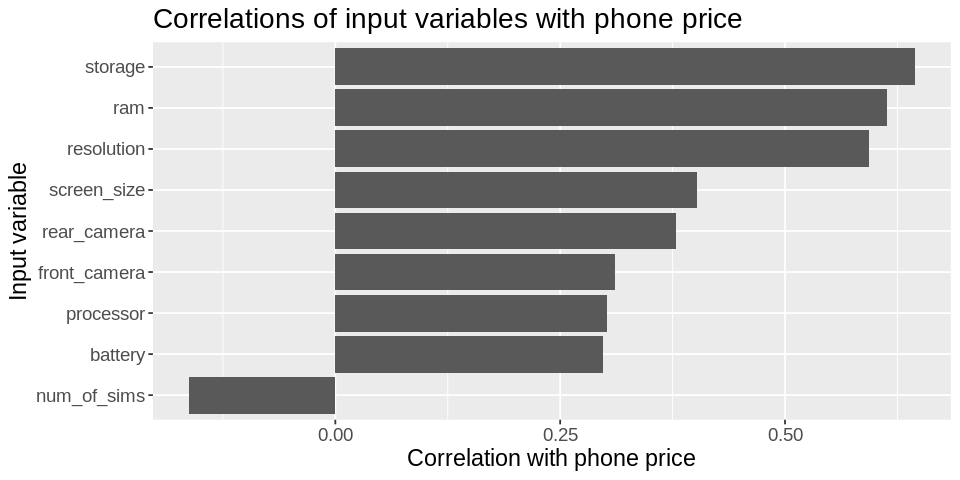

In [6]:
options(repr.plot.width = 8, repr.plot.height = 4)

# Plotting the distribution of calculated correlation coefficients
tibble(
  correlation = phone_data_corr$correlation,
  name = phone_data_numeric[-1] %>% colnames()
) %>%
  ggplot(aes(x = reorder(name, correlation), y = correlation)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Correlations of input variables with phone price",
    x = "Input variable",
    y = "Correlation with phone price"
  ) +
  theme(
    text = element_text(size = 14)
  ) +
  coord_flip()

The data shows that these variables are indeed the top 3 ones correlated with `price`, so the initial analysis of the data corresponds to scholarly claims and we expect these variables to be present in our final predictive model.

However, the correlation coefficients for these top 3 variables are below 0.7. This moderate correlation suggests that there may be important factors influencing the phone's price among the categorical variables, which we skipped here. Therefore, it's worth conducting a more rigorous analysis to find the variables significantly associated with `price`.

## Analysis (400 / 1000)

#### Splitting the Data Set

Before conducting the analysis, we split the complete wrangled data set into training and testing sets such that the training one contains 70% of the observations. This **holdout method** allows us to perform further analysis without touching the testing set, which is used as the new data while evaluating our future models.

In [7]:
# Adding `ID` column to the full data set
# (!!!) maybe change this to use the full phone_data instead of just numeric
data <- phone_data_numeric

data$ID <- rownames(data)

# (1) Shuffling the full data set
# (2) Selecting 70% of the observations
# (3) Assigning those to the training data set
phone_training <- data %>%
sample_n(size = nrow(data) * 0.7)

# Assigning the rest 30% of the observations to the testing set
phone_testing <- anti_join(
x = data,
y = phone_training,
by = "ID"
)

# Dropping the `ID` column from the created data sets
phone_training <- phone_training %>%
select(-ID)
phone_testing <- phone_testing %>%
select(-ID)

# Calculating the number of observations in training and testing sets
tibble(
data_set = c("training_data", "testing_data"),
num_of_obs = c(phone_training %>% nrow(), phone_testing %>% nrow())
)

data_set,num_of_obs
<chr>,<int>
training_data,951
testing_data,408


#### Multicollinearity Check

Multicollinearity occurs when there's a high correlation between input variables. This phenomenon presents a severe challenge to predictive modeling because a model containing such variables is not stable - a change in one input variable causes a significant alteration in another (Wu). Moreover, applying such a model in the real world is erroneous because it may induce overfitting, i.e., the model would perform well on the training set but predict poorly on the testing one (Wu).

Thus, we check for multicollinearity below. We can estimate its presence by creating a **correlation heat map** that visualizes "the strength of relationships between numerical variables" (Kumar).

In [8]:
# Creating a correlation matrix for all numeric variables
phone_data_corr_matrix <- phone_data_numeric %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("var1") %>%
  pivot_longer(-var1, names_to = "var2", values_to = "corr")

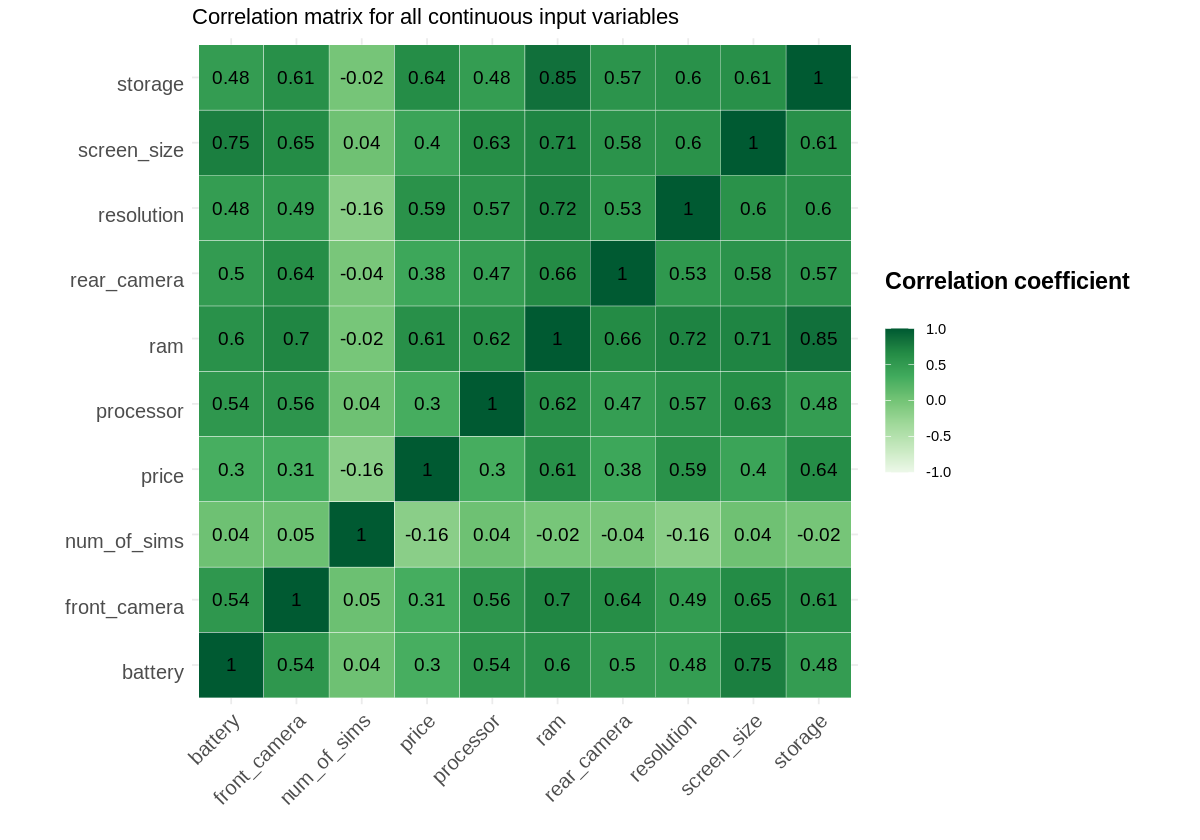

In [9]:
options(repr.plot.width = 10, repr.plot.height = 7)

phone_data_corr_matrix %>%
ggplot(aes(var1, var2)) +
geom_tile(aes(fill = corr), color = "white") +
scale_fill_distiller(
  "Correlation coefficient \n",
  palette = "Greens",
  direction = 1,
  limits = c(-1, 1)
) +
theme_minimal() +
labs(
  title = "Correlation matrix for all continuous input variables",
  x = "", y = "") +
theme(
  axis.text.x = element_text(
    angle = 45, vjust = 1,
    size = 12, hjust = 1
  ),
  axis.text.y = element_text(
    vjust = 1,
    size = 12, hjust = 1
  ),
  legend.title = element_text(size = 14, face = "bold")
) +
coord_fixed() +
geom_text(aes(x = var1,
              y = var2,
              label = round(corr, 2)),
          color = "black",
          size = 4
)

From the plot, we can observe the following variable pairs that have a high correlation, i.e., one with $\geq$ 0.7

| Variable pair               | Correlation value |
| --------------------------- | ----------------- |
| `storage` and `ram`         | 0.85              |
| `screen_size` and `battery` | 0.75              |
| `resolution` and `ram`      | 0.72              |
| `screen_size` and `ram`     | 0.71              |
| `ram` and `front_camera`    | 0.7               |

However, we need to rigorously calculate the multicollinearity to find whether the correlations presented above are problematic. For this, we create a function that:

1. Creates a **Multiple Linear Regression (MLR)** fitting `price` as a dependent variable and all other variables as independent ones
2. Finds each variable's **Variance Inflation Factor (VIF)**, which "measures how much the variance of an independent variable is influenced by its correlation with the other independent variables" (Potters)

In [10]:
# (1) Creates MLR for the `data_set` using `price` as a dependant variable and all the rest as input variables
# (2) Calculates the model's VIFs for each input variable and prints the highest 5 of them
calculate_vif <- function(data_set) {
  # Creating a multiple linear regression for `price` using all input variables from the given data set
  mlr <- data_set %>%
    lm(formula = price ~ .)

  # Using Variance Inflation Factor (VIF) to quantify the possible multicollinearity
  mlr %>%
    vif() %>%
    as.data.frame() %>%
    rename(GVIF = ".") %>%
    round(3) %>%
    arrange(desc(GVIF)) %>%
    head(5)
}

Now we can input the whole training set into this function and find the VIF for each input variable.

In [11]:
# Calculating VIF values using the whole training set
calculate_vif(phone_training)

,GVIF
,<dbl>
ram,6.176
storage,3.480
screen_size,3.400
front_camera,2.506
resolution,2.489


As the **GVIF** column of the table shows, VIF values for `ram` and `storage` are among the highest ones, which we expected because their correlation in the heat map was the highest.

Scholars argue that VIF values above 10 denote the multicollinearity problem, while some say that values above 5 are also problematic (Bock).

Therefore, we perform these remedies for dealing with high VIF values:
- Remove one or multiple highly correlated variables
- Adjust highly correlated variables so that their values are different and interpretable in a new way

In [12]:
# Calculating VIFs dropping `ram`
calculate_vif(phone_training %>% select(-ram))

,GVIF
,<dbl>
screen_size,3.393
front_camera,2.389
battery,2.318
resolution,2.223
storage,2.114


In [13]:
# Calculating VIFs dropping `ram` and `storage`
calculate_vif(phone_training %>% select(-c(ram, storage)))

,GVIF
,<dbl>
screen_size,3.296
battery,2.316
front_camera,2.262
resolution,2.073
rear_camera,2.045


In [14]:
# Adjusting `storage` column to indicate how much a phone's storage space is above the average one
phone_data_adjusted_storage <- phone_training %>%
  mutate(storage = storage - 64)

# Calculating VIFs for the adjusted `ram`
calculate_vif(phone_data_adjusted_storage)

,GVIF
,<dbl>
ram,6.176
storage,3.480
screen_size,3.400
front_camera,2.506
resolution,2.489


As the tables above show, dropping highly correlated variables yields lower VIFs. However, scholars consider those variables significant for predicting a phone's price (Listianingrum et al.), so we keep them to provide our future models with more information. Additionally, the highest VIF is still below 10, so we continue our investigation without changing the data.

#### MLR Full Model

!!! describe the process

In [15]:
# Building predictive Ordinary Least Squares LR model with all input variables
phone_model_full <- phone_training %>%
  lm(formula = price ~ .)
phone_model_full

# Obtaining out-of-sample predictions for `price` from the testing set using the full model
phone_model_full_test <- predict(
  object = phone_model_full,
  newdata = phone_testing
)

# Calculating the MSE value for the full model
phone_model_full_rmse <- rmse(
  preds = phone_model_full_test,
  actuals = phone_testing$price
)
phone_model_full_rmse

# Storing full model's MSE value to the results tibble
phone_rmses <- tibble(
  model = "OLS Full Regression",
  rmse = phone_model_full_rmse
)
phone_rmses


Call:
lm(formula = price ~ ., data = .)

Coefficients:
 (Intercept)       battery   screen_size    resolution     processor  
  128.617321     -0.008774     -4.390087      0.053082     -6.660624  
         ram       storage   rear_camera  front_camera   num_of_sims  
   25.722707      2.198330     -0.385539     -4.778191    -34.579818  


[1] 114.1929

model,rmse
<chr>,<dbl>
OLS Full Regression,114.1929


#### MLR Stepwise Selection Model
!!! describe the process and benefits

Subset selection object
Call: regsubsets.formula(x = price ~ ., nvmax = nrow(phone_training), 
    data = phone_training, method = "forward")
9 Variables  (and intercept)
             Forced in Forced out
battery          FALSE      FALSE
screen_size      FALSE      FALSE
resolution       FALSE      FALSE
processor        FALSE      FALSE
ram              FALSE      FALSE
storage          FALSE      FALSE
rear_camera      FALSE      FALSE
front_camera     FALSE      FALSE
num_of_sims      FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: forward

Subset selection object
Call: regsubsets.formula(x = price ~ ., nvmax = nrow(phone_training), 
    data = phone_training, method = "forward")
9 Variables  (and intercept)
             Forced in Forced out
battery          FALSE      FALSE
screen_size      FALSE      FALSE
resolution       FALSE      FALSE
processor        FALSE      FALSE
ram              FALSE      FALSE
storage          FALSE      FALSE
rear_camera      FALSE      FALSE
front_camera     FALSE      FALSE
num_of_sims      FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: forward
         battery screen_size resolution processor ram storage rear_camera
1  ( 1 ) " "     " "         " "        " "       " " "*"     " "        
2  ( 1 ) " "     " "         "*"        " "       " " "*"     " "        
3  ( 1 ) " "     " "         "*"        " "       " " "*"     " "        
4  ( 1 ) " "     " "         "*"        " "       " " "*"     " "        
5  ( 1 ) " "     " "         "*"        " "       "*" "*"  

n_input_vars,rss,bic,cp
<int>,<dbl>,<dbl>,<dbl>
1,15855989,-535.6761,171.392689
2,14506123,-613.4352,78.180654
3,13903076,-646.9578,37.645136
4,13719576,-652.7357,26.702070
5,13541834,-658.2792,16.165148
6,13398517,-661.5400,8.056393
7,13349176,-658.1911,6.576127
8,13343479,-651.7396,8.174255
9,13341008,-645.0582,10.000000


n_input_vars,rss,bic,cp
<int>,<dbl>,<dbl>,<dbl>
7,13349176,-658.1911,6.576127



Call:
lm(formula = price ~ resolution + battery + screen_size + processor + 
    ram + storage + front_camera + num_of_sims, data = .)

Coefficients:
 (Intercept)    resolution       battery   screen_size     processor  
  128.869619      0.052661     -0.009079     -4.679076     -6.596462  
         ram       storage  front_camera   num_of_sims  
   25.020411      2.196711     -4.938009    -34.242352  


[1] 114.167

model,rmse
<chr>,<dbl>
OLS Full Regression,114.1929
OLS Stepwise Reduced Regression,114.1670


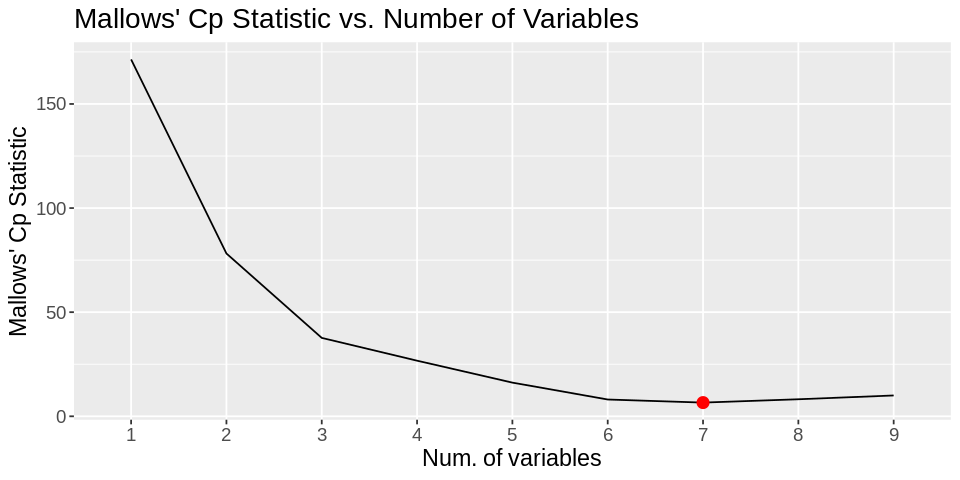

In [16]:
# Performing forward variable selection on the training set
phone_forward_sel <- regsubsets(
  x = price ~ .,
  nvmax = nrow(phone_training),
  data = phone_training,
  method = "forward"
)
phone_forward_sel

# Storing the summary statistics of the variable selection
phone_forward_sel_summary <- summary(phone_forward_sel)
phone_forward_sel_summary

# Storing variable selection metrics useful for approximating the test MSE
phone_forward_sel_summary_df <- tibble(
  n_input_vars = 1:9,
  rss = phone_forward_sel_summary$rss,
  bic = phone_forward_sel_summary$bic,
  cp = phone_forward_sel_summary$cp
)
phone_forward_sel_summary_df

# Saving the row with the smallest Cp value
min_cp <- phone_forward_sel_summary_df %>%
  filter(cp == min(phone_forward_sel_summary_df$cp))
min_cp

options(repr.plot.width = 8, repr.plot.height = 4)

# Plotting Cp values from the variable selection summary table
phone_forward_sel_summary_df %>%
  ggplot(aes(x = n_input_vars, y = cp)) +
  geom_line() +
  scale_x_discrete(limits = factor(1:9)) +
  geom_point(
    data = min_cp,
    color = "red",
    size = 3
  ) +
  labs(
    title = "Mallows' Cp Statistic vs. Number of Variables",
    x = "Num. of variables",
    y = "Mallows' Cp Statistic"
  ) +
  theme(text = element_text(size = 14))

# !!! select the variables according to seed
# Building a model using the variables selected by the stepwise forward selection
phone_model_stepwise <- phone_training %>%
  lm(formula = price ~ resolution +
    battery +
    screen_size +
    processor +
    ram +
    storage +
    front_camera +
    num_of_sims)
phone_model_stepwise

# Obtaining out-of-sample predictions for `price` from the testing set using the stepwise reduced model
phone_model_stepwise_test <- predict(
  object = phone_model_stepwise,
  newdata = phone_testing
)

# Calculating the MSE value for the stepwise reduced model
phone_model_stepwise_rmse <- rmse(
  preds = phone_model_stepwise_test,
  actuals = phone_testing$price
)
phone_model_stepwise_rmse

# Adding stepwise reduced model's MSE to the results tibble
phone_rmses <- phone_rmses %>%
  rbind(tibble(
    model = "OLS Stepwise Reduced Regression",
    rmse = phone_model_stepwise_rmse
  )) %>%
  unique()

phone_rmses

#### LASSO Model

!!! describe the process and benefits

[1] 0.46

,full_model,lasso
,<dbl>,<dbl>
(Intercept),128.617,102.659
battery,-0.009,-0.008
screen_size,-4.390,-0.397
resolution,0.053,0.050
processor,-6.661,-5.427
ram,25.723,21.332
storage,2.198,2.172
rear_camera,-0.386,0.000
front_camera,-4.778,-4.369


model,rmse
<chr>,<dbl>
OLS Full Regression,114.1929
OLS Stepwise Reduced Regression,114.1670
LASSO Regression with min MSE,114.2197


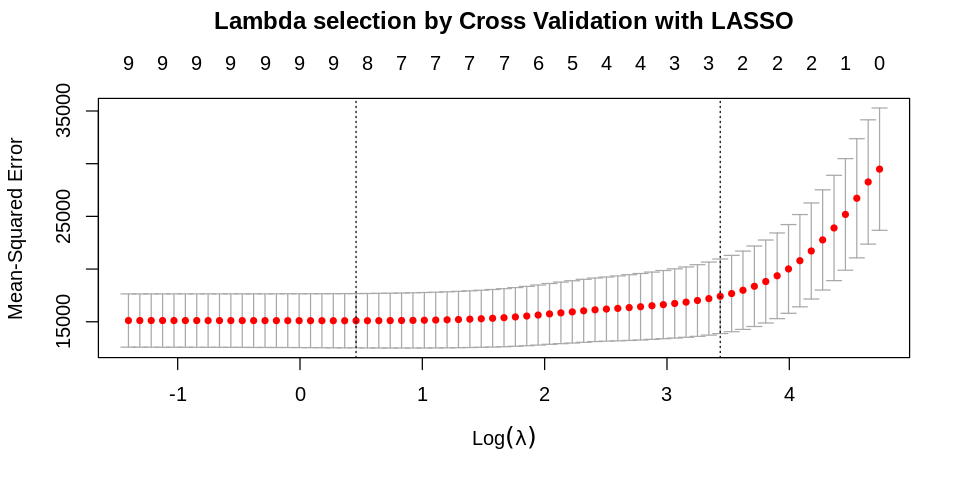

In [17]:
# Creating a matrix of all input variables from the training set
phone_training_matrix_x <- phone_training %>%
  select(-price) %>%
  as.matrix()

# Creating a matrix of responses from the training set
phone_training_matrix_y <- phone_training %>%
  select(price) %>%
  as.matrix()

# Creating a matrix of all input variables from the testing set
phone_testing_matrix_x <- phone_testing %>%
  select(-price) %>%
  as.matrix()

# Creating a matrix of responses from the testing set
phone_testing_matrix_y <- phone_testing %>%
  select(price) %>%
  as.matrix()

# Finding the optimal value of lambda, the penalty parameter
phone_cv_lambda <- cv.glmnet(
  x = phone_training_matrix_x,
  y = phone_training_matrix_y,
  alpha = 1
)

# Plotting the range of lambda values vs. MSE
phone_cv_lambda %>%
  plot(
    main = "Lambda selection by Cross Validation with LASSO\n\n"
  )

# Storing the min value of lambda
phone_lambda_min <- round(phone_cv_lambda$lambda.min, 3)

# Displaying the min value of lambda
round(log(phone_lambda_min), 2)

# Building LASSO model with the min lambda
phone_model_lasso <- glmnet(
  x = phone_training_matrix_x,
  y = phone_training_matrix_y,
  alpha = 1,
  lambda = phone_lambda_min
)

# Comparing coefficients from the full MLR model and LASSO with min lambda
data.frame(
  full_model = coef(phone_model_full),
  lasso = c(phone_model_lasso$a0, as.vector(phone_model_lasso$beta))
) %>%
  round(3)

# Obtaining out-of-sample predictions for `price` from the testing set using the lasso model
phone_model_lasso_test <- predict(
  object = phone_model_lasso,
  newx = phone_testing_matrix_x
)

# Calculating the MSE value for the lasso model
phone_model_lasso_rmse <- rmse(
  preds = phone_model_lasso_test,
  actuals = phone_testing$price
)

# Adding LASSO model's MSE to the results tibble
phone_rmses <- phone_rmses %>%
  rbind(tibble(
    model = "LASSO Regression with min MSE",
    rmse = phone_model_lasso_rmse
  )) %>%
  unique()

phone_rmses %>%
  as.data.frame()

#### SLR Model

!!! choose the input variable and fit the model

## Evaluation (300)

!!! compare the models' MSE and discuss their limitations

!!! discuss assumptions of linear regression

Our analysis has multiple crucial limitations that may hinder its findings.

1. The smartphone market is quickly evolving, so even though the data set was published in 2022, it misses variables describing critical features of modern smartphones. For instance, the data does not have variables for NFS module or 5G compatibility, which may influence smartphone prices today.

## Conclusion (200)

## References

“Best Mobile Phones in India | Latest & New Smartphones Price.” *Gadgets 360*, 2020, www.gadgets360.com/mobiles/best-phones. Accessed 3 Dec. 2022.

Bock, Tim. “What Are Variance Inflation Factors (VIFs)? | Displayr.com.” *Displayr*, 6 Apr. 2018, www.displayr.com/variance-inflation-factors-vifs/.

Garai, Pratik. “Mobile Phone Specifications and Prices.” *Www.kaggle.com*, 14 Aug. 2022, www.kaggle.com/datasets/pratikgarai/mobile-phone-specifications-and-prices. Accessed 4 Dec. 2022.

Hilsenteger, Lewis. “IPhone 14 ESIM Controversy Explained.” *Www.youtube.com*, 12 Sept. 2022, www.youtube.com/watch?t=543&v=DLILlKdELEk&feature=youtu.be. Accessed 3 Dec. 2022.

K. Srujan Raju, et al. *Data Engineering and Communication Technology*. Springer, 9 Jan. 2020, p. 773.

Kobie, Nicole. “Why Does Buying a New Phone Have to Be so - ProQuest.” *Www.proquest.com*, Apr. 2017, www.proquest.com/docview/1985885659?accountid=14656&forcedol=true&pq-origsite=summon. Accessed 3 Dec. 2022.

Kumar, Ajitesh. “Correlation Concepts, Matrix & Heatmap Using Seaborn.” *Data Analytics*, 16 Apr. 2022, vitalflux.com/correlation-heatmap-with-seaborn-pandas/#:~:text=with%20each%20other.-.

Listianingrum, T, et al. “Smartphone Hedonic Price Study Based on Online Retail Price in Indonesia.” *Journal of Physics: Conference Series*, vol. 1863, no. 1, 1 Mar. 2021, p. 012032, 10.1088/1742-6596/1863/1/012032. Accessed 1 May 2022.

Potters, Charles. “Variance Inflation Factor (VIF).” *Investopedia*, 26 July 2022, www.investopedia.com/terms/v/variance-inflation-factor.asp#:~:text=Variance%20inflation%20factor%20measures%20how.

Tanveer, Muhammad, et al. “Mobile Phone Buying Decisions among Young Adults: An Empirical Study of Influencing Factors.” *Sustainability*, vol. 13, no. 19, 27 Sept. 2021, p. 10705, 10.3390/su131910705. Accessed 8 Oct. 2021.

Wu, Songhao. “Multi-Collinearity in Regression.” *Medium*, 23 May 2020, towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea.